In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #用于设置设备配置。如果有可用的GPU（CUDA），则使用GPU，否则使用CPU

# Hyper-parameters 定义了训练过程中的超参数，包括训练的轮数（num_epochs）、每个批次的大小（batch_size）和学习率（learning_rate）
num_epochs = 25
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules 定义了图像预处理的步骤。首先对图像进行填充（Pad），然后随机水平翻转（RandomHorizontalFlip），接着随机裁剪（RandomCrop），最后将图像转换为张量（ToTensor）
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset 这段代码加载了CIFAR-10数据集。train_dataset用于训练，test_dataset用于测试。训练数据集应用了之前定义的预处理步骤，而测试数据集只进行了张量转换。
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transforms.ToTensor())

# Data loader 这段代码创建了数据加载器。train_loader用于加载训练数据，test_loader用于加载测试数据。训练数据加载器设置了shuffle=True，以便在每个epoch时打乱数据。
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 96.5MB/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


![resnetimage](https://user-images.githubusercontent.com/30661597/78585170-f4ac7c80-786b-11ea-8b00-8b751c65f5ca.PNG)

In [3]:
def conv3x3(in_channels, out_channels, stride=1):
  '''
  这段代码定义了一个3x3卷积层的函数。in_channels是输入通道数，out_channels是输出通道数，stride是步幅。卷积层的核大小为3x3，填充为1，且不使用偏置。
  '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        '''
        这段代码定义了一个残差块（Residual Block）类。__init__方法初始化了残差块的各个层，包括两个3x3卷积层、两个批归一化层（BatchNorm）和一个ReLU激活函数。downsample参数用于调整输入的尺寸以匹配输出
        '''
        super(ResidualBlock, self).__init__()
        # 第一个卷积层，可能会改变输入的尺寸
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
         # 第二个卷积层，保持输入尺寸不变
        self.conv2 = conv3x3(out_channels, out_channels)# 默认stride=1 这一行代码中没有指定stride参数，这是因为在残差块中，第二个卷积层通常不需要改变输入的尺寸。
        #具体来说，残差块的设计目的是为了在保持输入尺寸不变的情况下，通过卷积操作提取特征。第一个卷积层可能会改变输入的尺寸（通过指定stride参数），但第二个卷积层通常保持输入尺寸不变（默认stride=1），以便将卷积后的输出与输入进行逐元素相加。
        #在前向传播过程中，第二个卷积层的输出将与输入（或下采样后的输入）进行逐元素相加。因此，第二个卷积层不需要改变输入的尺寸。
        self.bn2 = nn.BatchNorm2d(out_channels)
         # 下采样层，用于匹配输入和输出的尺寸
        self.downsample = downsample

    def forward(self, x):
        '''
        这段代码定义了前向传播函数。首先保存输入x为residual。然后依次通过第一个卷积层、批归一化层和ReLU激活函数。接着通过第二个卷积层和批归一化层。如果downsample不为空，则对residual进行下采样。最后将out和residual相加，并通过ReLU激活函数
        '''
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        '''
        这段代码定义了一个ResNet类。__init__方法初始化了ResNet的各个层，包括一个卷积层、批归一化层、ReLU激活函数、三个残差层、一个平均池化层和一个全连接层。
        block参数指定了残差块的类型，layers参数指定了每个残差层的块数，num_classes参数指定了分类的类别数
        '''
        super(ResNet, self).__init__()
        self.in_channels = 16 # 输入通道为16 首先，输入通道的数量这是16，因为如果你回到这里，那么这里的输入通道数为16。所以我们取输入图像，由于它是 RGB 图像，因此它有三个通道，我们将通过 16 个过滤器对其进行处理。
                              # 因此我们有 16 个特征图。那么这个网络的输入通道数是 16，所以self.in_channels等于16。
        self.conv = conv3x3(3, 16) #因此输入通道的数量就是图像，也就是三。这是一个 RGB 图像。并且输出通道数基本上是 16 个，
        self.bn = nn.BatchNorm2d(16) #因为我们有 16 个特征图
        self.relu = nn.ReLU(inplace=True)
        #我们有三层, 上面图里的蓝绿红
        self.layer1 = self.make_layer(block, 16, layers[0], stride = 1) # layer will be a list: [2,2,2] 我们有三层，对于每一层，对于这个特定的架构，我们有两个残差块。这就是为什么这里有三个元素的列表。所以列表的长度基本上就是层数，
                                                            #列表中的元素指定每层有多少个残差块。在这种情况下，我们在每一层都有两个残差块。所以对于第一层，我们需要获取残差块的数量。基本上是通过列表的第一个元素，因此层数为零。
        self.layer2 = self.make_layer(block, 32, layers[1], stride = 2) #步幅stride=2，表示空间尺寸减半
        self.layer3 = self.make_layer(block, 64, layers[2], stride = 2)
        self.avg_pool = nn.AvgPool2d(8) #那么我们来看看为什么这里的尺寸达到8。这里我们有32×32，并且这种情况还在持续。到目前为止，我们有32×32。现在，我们除以2。
                                        #因此32除以2等于16。到目前为止是16个。现在在第三层，我们除以2。16除以2等于8。这就是我们达到这个规模的原因，特征图增加到8个。
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        '''
        这段代码定义了一个辅助函数make_layer，用于创建一个残差层。block参数指定了残差块的类型，out_channels参数指定了输出通道数，
        blocks参数指定了残差块的数量，stride参数指定了步幅。如果步幅不为1或者输入通道数不等于输出通道数，则需要进行下采样。然后创建一个包含多个残差块的序列，并返回这个序列
        '''
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels): #如果步幅stride不等于1，或者输入通道数self.in_channels不等于输出通道数out_channels，则需要进行下采样
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        这段代码定义了前向传播函数。输入x依次通过卷积层、批归一化层、ReLU激活函数、三个残差层、平均池化层和全连接层，最后返回输出。
        '''
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

在`make_layer`方法中，`downsample`部分的代码是为了确保输入和输出的尺寸匹配，以便在残差连接（skip connection）中进行逐元素相加。具体来说，当输入的尺寸或通道数与输出的尺寸或通道数不匹配时，需要通过下采样（downsample）来调整输入的尺寸和通道数。

以下是对这段代码的详细解释：

```python
def make_layer(self, block, out_channels, blocks, stride=1):
    downsample = None
    if (stride != 1) or (self.in_channels != out_channels):
        downsample = nn.Sequential(
            conv3x3(self.in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(out_channels)
        )
    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels
    for i in range(1, blocks):
        layers.append(block(out_channels, out_channels))
    return nn.Sequential(*layers)
```

### 代码解释

1. **下采样条件判断**：
    ```python
    if (stride != 1) or (self.in_channels != out_channels):
    ```
    这行代码检查是否需要下采样。如果步幅`stride`不等于1，或者输入通道数`self.in_channels`不等于输出通道数`out_channels`，则需要进行下采样。

2. **下采样操作**：
    ```python
    downsample = nn.Sequential(
        conv3x3(self.in_channels, out_channels, stride=stride),
        nn.BatchNorm2d(out_channels)
    )
    ```
    如果需要下采样，则创建一个包含卷积层和批归一化层的序列（`nn.Sequential`）。具体操作如下：
    - `conv3x3(self.in_channels, out_channels, stride=stride)`：使用步幅为`stride`的3x3卷积层，将输入通道数`self.in_channels`转换为输出通道数`out_channels`，并调整空间尺寸。
    - `nn.BatchNorm2d(out_channels)`：对输出进行批归一化。

3. **创建残差块**：
    ```python
    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels
    ```
    创建第一个残差块，并将其添加到`layers`列表中。第一个残差块的输入通道数为`self.in_channels`，输出通道数为`out_channels`，步幅为`stride`，并且包含下采样操作。然后更新`self.in_channels`为`out_channels`，以便后续的残差块使用。

4. **添加更多残差块**：
    ```python
    for i in range(1, blocks):
        layers.append(block(out_channels, out_channels))
    ```
    添加更多的残差块，每个残差块的输入和输出通道数都为`out_channels`，步幅为默认值1。

5. **返回残差层**：
    ```python
    return nn.Sequential(*layers)
    ```
    将所有的残差块组合成一个序列，并返回这个序列。

### 代码示例
为了更清楚地说明这一点，以下是一个完整的ResNet实现示例：

```python
import torch
import torch.nn as nn

def conv3x3(in_channels, out_channels, stride=1):
    """3x3 卷积层，带填充"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        # 初始卷积层
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # 残差层
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        # 平均池化层
        self.avg_pool = nn.AvgPool2d(8)
        # 全连接层
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        """创建残差层"""
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """前向传播"""
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# 测试
x = torch.randn(1, 3, 32, 32)  # 输入张量
model = ResNet(ResidualBlock, [2, 2, 2], num_classes=10)
out = model(x)
print(out.shape)  # 输出张量的形状
```

在这个示例中，`make_layer`方法确保了每个残差层的输入和输出尺寸匹配，从而实现了有效的残差连接。

将所有的残差块组合成一个序列并返回这个序列的主要原因是为了简化代码结构和提高代码的可读性和可维护性。具体来说，使用`nn.Sequential`将多个层组合在一起有以下几个优点：

### 1. 简化代码结构
使用`nn.Sequential`可以将多个层组合成一个模块，这样在前向传播时只需要调用一次即可，而不需要逐个调用每个层。这使得代码更加简洁和易于理解。

### 2. 提高可读性
将多个残差块组合成一个序列，可以清晰地表示网络的层次结构，使得代码更具可读性。读者可以一目了然地看到每个残差层包含的具体块数和结构。

### 3. 便于管理和修改
使用`nn.Sequential`可以方便地管理和修改网络结构。例如，如果需要调整某个残差层的块数或添加新的层，只需要修改`make_layer`方法中的参数即可，而不需要修改前向传播函数中的代码。

### 4. 兼容性和一致性
PyTorch中的许多高级API和工具（如`torchvision.models`中的预训练模型）都使用了`nn.Sequential`来定义网络结构。使用这种方式可以确保代码与这些工具和API的兼容性和一致性。

### 代码示例
在前面的示例中，`make_layer`方法使用`nn.Sequential`将多个残差块组合成一个序列，并返回这个序列。这样在前向传播函数中，只需要调用一次`self.layer1(out)`即可完成整个残差层的前向传播，而不需要逐个调用每个残差块。这使得代码更加简洁和易于维护。

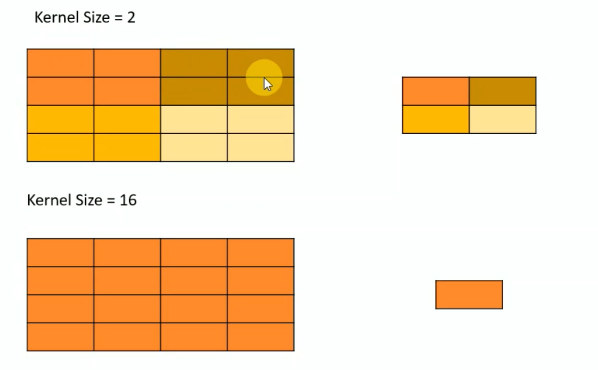

`out = out.view(out.size(0), -1)` 是 PyTorch 中用于改变张量形状的一种操作。具体来说，这行代码的作用是将一个多维张量展平成一个二维张量，以便将其传递给全连接层（线性层）。

### 详细解释

1. **`out.size(0)`**:
   - `out.size(0)` 返回张量 `out` 在第一个维度上的大小，通常是批次大小（batch size）。例如，如果 `out` 的形状是 `(batch_size, channels, height, width)`，那么 `out.size(0)` 就是 `batch_size`。

2. **`-1`**:
   - `-1` 是一个特殊的值，表示自动计算该维度的大小，以确保总元素数量不变。PyTorch 会根据张量的总元素数量和其他维度的大小来推断出 `-1` 所代表的具体值。

3. **`view` 方法**:
   - `view` 方法用于重新调整张量的形状。它类似于 NumPy 中的 `reshape` 方法。`view` 方法不会改变张量的数据，只会改变张量的形状。

### 示例

假设 `out` 的形状是 `(batch_size, channels, height, width)`，例如 `(32, 64, 8, 8)`，即批次大小为 32，通道数为 64，高度和宽度均为 8。

```python
import torch

# 假设 out 是一个形状为 (32, 64, 8, 8) 的张量
out = torch.randn(32, 64, 8, 8)

# 使用 view 方法将 out 展平成形状为 (32, 64*8*8) 的张量
out = out.view(out.size(0), -1)

print(out.shape)  # 输出: torch.Size([32, 4096])
```

在这个示例中，`out.view(out.size(0), -1)` 将 `out` 从形状 `(32, 64, 8, 8)` 展平成形状 `(32, 4096)`，其中 `4096` 是 `64 * 8 * 8` 的结果。

### 为什么需要这样做？

在卷积神经网络（CNN）中，卷积层和池化层的输出通常是一个多维张量（例如 `(batch_size, channels, height, width)`）。然而，全连接层（线性层）期望输入是一个二维张量（例如 `(batch_size, num_features)`）。因此，在将卷积层的输出传递给全连接层之前，需要将其展平成一个二维张量。


In [5]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

好的，我会逐行解释这段代码，并提供一些优化建议。

```python
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
```
1. `model = ResNet(ResidualBlock, [2, 2, 2])`:
   - 这行代码创建了一个ResNet模型实例。
   - `ResNet`是一个神经网络模型类，`ResidualBlock`是其使用的残差块类。
   - `[2, 2, 2]`是一个列表，表示每个阶段的残差块数量。
2. `.to(device)`:
   - 这部分代码将模型移动到指定的设备（例如GPU或CPU）。
   - `device`是一个变量，通常是`torch.device('cuda')`或`torch.device('cpu')`。

```python
criterion = nn.CrossEntropyLoss()
```
1. `criterion = nn.CrossEntropyLoss()`:
   - 这行代码定义了损失函数。
   - `nn.CrossEntropyLoss()`是PyTorch中的交叉熵损失函数，常用于分类任务。

```python
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```
1. `optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)`:
   - 这行代码定义了优化器。
   - `torch.optim.Adam`是PyTorch中的Adam优化器。
   - `model.parameters()`将模型的参数传递给优化器。
   - `lr=learning_rate`设置学习率，`learning_rate`是一个预定义的变量。

In [6]:
decay = 0
model.train()
for epoch in range(num_epochs):

    # Decay the learning rate every 20 epochs
    if (epoch+1) % 20 == 0:
        decay+=1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)
        print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/25], Step [100/500] Loss: 1.4844
Epoch [1/25], Step [200/500] Loss: 1.4638
Epoch [1/25], Step [300/500] Loss: 1.3060
Epoch [1/25], Step [400/500] Loss: 1.2883
Epoch [1/25], Step [500/500] Loss: 1.2591
Epoch [2/25], Step [100/500] Loss: 1.0537
Epoch [2/25], Step [200/500] Loss: 1.0306
Epoch [2/25], Step [300/500] Loss: 1.1265
Epoch [2/25], Step [400/500] Loss: 1.0905
Epoch [2/25], Step [500/500] Loss: 0.9362
Epoch [3/25], Step [100/500] Loss: 0.8538
Epoch [3/25], Step [200/500] Loss: 1.1232
Epoch [3/25], Step [300/500] Loss: 0.8245
Epoch [3/25], Step [400/500] Loss: 0.7725
Epoch [3/25], Step [500/500] Loss: 0.6914
Epoch [4/25], Step [100/500] Loss: 0.7163
Epoch [4/25], Step [200/500] Loss: 0.8014
Epoch [4/25], Step [300/500] Loss: 0.6534
Epoch [4/25], Step [400/500] Loss: 0.6866
Epoch [4/25], Step [500/500] Loss: 0.6844
Epoch [5/25], Step [100/500] Loss: 0.6692
Epoch [5/25], Step [200/500] Loss: 0.6515
Epoch [5/25], Step [300/500] Loss: 0.8331
Epoch [5/25], Step [400/500] Loss:

好的，我会逐行解释这段代码，并提供一些优化建议。

```python
decay = 0
```
1. `decay = 0`:
   - 初始化一个变量`decay`，用于控制学习率的衰减次数。

```python
model.train()
```
2. `model.train()`:
   - 将模型设置为训练模式。这会启用诸如Dropout等训练时特有的层。

```python
for epoch in range(num_epochs):
```
3. `for epoch in range(num_epochs):`:
   - 开始一个循环，遍历所有的训练周期（epoch）。
   - `num_epochs`是预定义的变量，表示训练的总周期数。

```python
    if (epoch+1) % 20 == 0:
        decay+=1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)
        print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))
```
4. `if (epoch+1) % 20 == 0:`:
   - 每20个周期衰减一次学习率。
5. `decay+=1`:
   - 增加衰减计数。
6. `optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)`:
   - 更新优化器的学习率，新的学习率是初始学习率乘以0.5的`decay`次方。
7. `print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))`:
   - 打印新的学习率。

```python
    for i, (images, labels) in enumerate(train_loader):
```
8. `for i, (images, labels) in enumerate(train_loader):`:
   - 遍历训练数据加载器`train_loader`，获取批次索引`i`，以及批次数据`images`和`labels`。

```python
        images = images.to(device)
        labels = labels.to(device)
```
9. `images = images.to(device)`:
   - 将图像数据移动到指定的设备（例如GPU）。
10. `labels = labels.to(device)`:
    - 将标签数据移动到指定的设备。

```python
        outputs = model(images)
```
11. `outputs = model(images)`:
    - 将图像数据输入模型，获取模型的输出。

```python
        loss = criterion(outputs, labels)
```
12. `loss = criterion(outputs, labels)`:
    - 计算模型输出与真实标签之间的损失。

```python
        optimizer.zero_grad()
```
13. `optimizer.zero_grad()`:
    - 清空优化器的梯度。

```python
        loss.backward()
```
14. `loss.backward()`:
    - 反向传播，计算梯度。

```python
        optimizer.step()
```
15. `optimizer.step()`:
    - 更新模型参数。

```python
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
```
16. `if (i+1) % 100 == 0:`:
    - 每100个批次打印一次训练信息。
17. `print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))`:
    - 打印当前周期、批次和损失值。

### 代码优化建议
1. 可以使用`torch.optim.lr_scheduler`来自动管理学习率衰减，例如`StepLR`：
   ```python
   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
   ```

2. 在每个周期结束时调用`scheduler.step()`：
   ```python
   for epoch in range(num_epochs):
       for i, (images, labels) in enumerate(train_loader):
           images = images.to(device)
           labels = labels.to(device)
           outputs = model(images)
           loss = criterion(outputs, labels)
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
           
           if (i+1) % 100 == 0:
               print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
       
       scheduler.step()
       print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))
   ```

这些优化建议可以帮助你更高效地管理学习率衰减。希望这些解释和建议对你有帮助！

In [7]:
#Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 86.06 %


好的，我会逐行解释这段代码，并提供一些优化建议。

```python
# Test the model
model.eval()
```
1. `model.eval()`:
   - 将模型设置为评估模式。这会禁用Dropout等训练时特有的层，并使用批归一化的移动平均值。

```python
with torch.no_grad():
```
2. `with torch.no_grad():`:
   - 禁用梯度计算，以减少内存消耗和加速计算。这在评估或推理时非常有用。

```python
    correct = 0
    total = 0
```
3. `correct = 0`:
   - 初始化一个变量`correct`，用于记录预测正确的样本数量。
4. `total = 0`:
   - 初始化一个变量`total`，用于记录测试样本的总数量。

```python
    for images, labels in test_loader:
```
5. `for images, labels in test_loader:`:
   - 遍历测试数据加载器`test_loader`，获取批次数据`images`和`labels`。

```python
        images = images.to(device)
        labels = labels.to(device)
```
6. `images = images.to(device)`:
   - 将图像数据移动到指定的设备（例如GPU）。
7. `labels = labels.to(device)`:
   - 将标签数据移动到指定的设备。

```python
        outputs = model(images)
```
8. `outputs = model(images)`:
   - 将图像数据输入模型，获取模型的输出。

```python
        _, predicted = torch.max(outputs.data, 1)
```
9. `_, predicted = torch.max(outputs.data, 1)`:
   - 获取每个样本的预测类别。`torch.max`返回每行的最大值及其索引，这里我们只需要索引（即预测类别）。

```python
        total += labels.size(0)
```
10. `total += labels.size(0)`:
    - 累加当前批次的样本数量到`total`。

```python
        correct += (predicted == labels).sum().item()
```
11. `correct += (predicted == labels).sum().item()`:
    - 计算当前批次中预测正确的样本数量，并累加到`correct`。

```python
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
```
12. `print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))`:
    - 打印模型在测试集上的准确率。

### 代码优化建议
1. 为了提高代码的可读性和可维护性，可以将评估过程封装成一个函数：
   ```python
   def evaluate_model(model, test_loader, device):
       model.eval()
       with torch.no_grad():
           correct = 0
           total = 0
           for images, labels in test_loader:
               images = images.to(device)
               labels = labels.to(device)
               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()
           accuracy = 100 * correct / total
           print('Accuracy of the model on the test images: {} %'.format(accuracy))
       return accuracy
   ```

2. 在训练循环结束后调用该函数：
   ```python
   accuracy = evaluate_model(model, test_loader, device)
   ```

3. 如果测试集较大，可以考虑使用`torch.cuda.empty_cache()`来释放显存：
   ```python
   with torch.no_grad():
       correct = 0
       total = 0
       for images, labels in test_loader:
           images = images.to(device)
           labels = labels.to(device)
           outputs = model(images)
           _, predicted = torch.max(outputs.data, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
           torch.cuda.empty_cache()  # 释放显存
       accuracy = 100 * correct / total
       print('Accuracy of the model on the test images: {} %'.format(accuracy))
   ```

这些优化建议可以帮助你更高效地评估模型。希望这些解释和建议对你有帮助！